<a href="https://colab.research.google.com/github/ericmuckley/code/blob/master/pedotpss_multimode_part_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the data

This section will use the data formatted in Part I and pull it from Github
by first cloning the github repository.


In [0]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# clone the entire github repository
%cd /content/
!rm -rf cloned-data
!git clone -l -s git://github.com/ericmuckley/datasets.git cloned-data

# navigate to the repo
%cd cloned-data
print('-------------------------- Files in repo: --------------------------')
!ls

def open_pickle(filename):
    '''
    Opens serialized Python pickle file as a dictionary.
    Filename should be something like 'saved_data.pkl'.
    '''
    with open(filename, 'rb') as handle:
        dic = pickle.load(handle)
    return dic

# open the file we want
dic = open_pickle('pp_multimode.pkl')
# get out of the data folder
%cd /content/

/content
Cloning into 'cloned-data'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 67 (delta 27), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (67/67), 6.44 MiB | 12.04 MiB/s, done.
Resolving deltas: 100% (27/27), done.
/content/cloned-data
-------------------------- Files in repo: --------------------------
hops_enose_response.csv        milk__FTIR.csv	pedotpss_multimode.xlsx
milk_drop_QCM_aug12_2019.xlsx  milk__RAMAN.csv	pp_multimode.pkl
milk_FTIR_by_hour.csv	       milk__UVVIS.csv	README.md
/content


In [3]:
# examine the data
for key in dic:
    print('%s: %s, shape: %s' %(
        key, str(type(dic[key])), str(np.shape(dic[key]))))
print('\nscalars columns:')
print(np.array(list(dic['scalars'])))

spe_n: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
spe_k: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
spe_psi: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
spe_delta: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
eis_z: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
eis_phase: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
eis_rez: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
eis_imz: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
iv: <class 'pandas.core.frame.DataFrame'>, shape: (200, 190)
scalars: <class 'pandas.core.frame.DataFrame'>, shape: (189, 27)

scalars columns:
['rh' 'df1' 'dd1' 'df7' 'dd7' 'df11' 'dd11' 'dmu1' 'deta1' 'dmu7' 'deta7'
 'dmu11' 'deta11' 'cvarea10' 'cvarea50' 'cvarea100' 'cvarea300' 'cvmax10'
 'cvmax50' 'cvmax100' 'cvmax300' 'ivmaxcurr' 'ivmincurr' 'z1hz' 'phi1hz'
 'n600' 'k600']


#  Creating regression models using scikit-learn

Now that the data is clean and formatted, we can prepare it for use in building
a predictive machine learning model. For this model we will look at just 
the scalar data.

This section provides functions for splitting and examining the datasets,
fitting the model, and testing the model.

## Standardize data and split into training & testing sets

Before fitting the model, we standardize (scale and normalize) the data.
Then we can split the standardized data into training and testing sets, using
specified row indices to designate the samples in each set.

The data is split into 4 sets and input sets are scaled:

**in_train**: input features for training

**out_train**: output/target features for training

**in_test**: input features for testing

**out_test**: output/target features for testing

We use our own custom function for this so we can perform it again later.
The function will take the dataset as an input in the form of a Pandas 
DataFrame. The funtion will also need the names of input and target columns,
and lists of which samples (row indices) we will use for training and testing.
Then we write a custom function to fit the model and make predictions from
the trained model. 

In [0]:
# we import the necessary libraries again here so we can start from this
# section in the future

from sklearn.preprocessing import StandardScaler
import numpy.polynomial.polynomial as poly

def plot_setup(labels=['X', 'Y'], size=16, setlimits=False, limits=[0,1,0,1]):
    # This can be called with Matplotlib for setting axes labels,
    # setting axes ranges, and setting the font size of plot labels.
    # Should be called between plt.plot() and plt.show() commands.
    plt.rcParams['xtick.labelsize'] = size 
    plt.rcParams['ytick.labelsize'] = size
    plt.xlabel(str(labels[0]), fontsize=size)
    plt.ylabel(str(labels[1]), fontsize=size)
    if setlimits:
        plt.xlim((limits[0], limits[1]))
        plt.ylim((limits[2], limits[3]))


def find_key_of_value(value, dictionary):
    '''
    Checks if a value exists inside any keys of a dictionary.
    Returns a list of keys in which the value resides, and a list of the
    other values in the keys.
    '''
    keys = []
    other_values = []
    for key in dictionary:
        # check if value resides in the key 
        if value in dictionary[key]:
            keys.append(key)
            # find other values inside the key
            for val in dictionary[key]:
                if val != value:
                    other_values.append(val)
    return keys[0], other_values



def format_for_ml(df0, target_feature, train_samples,
                  drop_features=None, scaler=StandardScaler()):
    '''
    Splits a Pandas DataFrame (df0) into different arrays for 
    use in ML models. The df is split into input and output (target)
    feature by column name. Columns which are not target_feature
    are used as input features. 

    The df is split into training and testing arrays according
    to the list of indices (rows) designated by train_samples.
    The rows which are not used for training are used as test_samples.
    Features can be dropped by using a list of column names in the
    drop_features agument.
    
    Use a scaler to create scaled arrays for use in the ML model.
    The output is a dictionary:
    in_train: input features for training
    out_train: target feature for training
    in_test: input features for testing
    out_test: target feature for testing
    in_train_s: scaled input features for training
    out_train_s: scaled target feature for training
    in_test_s: scaled input features for testing
    out_test_s: scaled target feature for testing
    '''
    df = df0.copy()
    # drop unwanted features
    if drop_features is not None:
        df.drop(drop_features, inplace=True, axis=1)

    # for input features, use all columns that are not used as target_feature
    input_features = [col for col in list(df) if col != target_feature]
    # for test samples, use all samples that are not used as training samples
    test_samples = np.setdiff1d(df.index.values, train_samples)

    # create datasets
    in_train = df[input_features].iloc[train_samples]
    out_train = df[target_feature].iloc[train_samples]
    in_test = df[input_features].iloc[test_samples]
    out_test = df[target_feature].iloc[test_samples]

    # fit the standardization scaler
    scaler_in = scaler
    scaler_in.fit(df[input_features].values)
    
    # standardize the input datasets using the scaler
    in_train_s = scaler.transform(in_train.values)
    in_test_s = scaler.transform(in_test.values)

    # store datasets in a dictionary
    ds = {
        'scaler': scaler,
        'in_train': in_train,
        'out_train': out_train,
        'in_test': in_test,
        'out_test': out_test,
        'in_train_s': in_train_s,
        'in_test_s': in_test_s,
        'target_feature': target_feature}
    return ds


def examine_ml_datasets(ds):
    # examine the datasets produced by the "format_for_ml" function
    # loop over each dataset in the dictionary
    for d in ds:
        if isinstance(ds[d], pd.DataFrame):
            print('%s: shape=%s, columns=%s' %(
                str(d), str(ds[d].shape), str(list(ds[d]))))
        if isinstance(ds[d], np.ndarray):
            print('%s: shape=%s' %(str(d), str(ds[d].shape)))
        if isinstance(ds[d], str):
            print('%s: %s' %(d, ds[d]))

def deploy_model(model, dataset, ind_var_name='rh'):
    '''
    Fits a regression model, makes predictions with the model, and assesses
    quality of the model. For "model" use a model (e.g. sklearn SVR()),
    and for "ds" use dataset from the output of the function "format_for_ml"
    '''
    # fit the model using standardized input and output training sets
    model.fit(ds['in_train_s'], ds['out_train'])
    # make predictions based on the training data
    train_prediction = model.predict(ds['in_train_s'])
    # make predictions based on the testing data
    test_prediction = model.predict(ds['in_test_s'])
    # assess performance of the model
    model_score = model.score(ds['in_test_s'], ds['out_test'])
    raw_error = np.abs(test_prediction - ds['out_test'])
    avg_percent_error = np.mean(np.abs(raw_error/dataset['out_test']))*100
    # buld a dictionary to summarize model results
    model_results = {
        'model': model,
        'raw_error': raw_error,
        'model_score': model_score,
        'test_prediction': test_prediction,
        'train_prediction': train_prediction,
        'avg_percent_error': avg_percent_error}
    return model_results


def plot_reg_results(ds, model_results, ind_var_name=None,
                     model_name='', plot_scatter=False):
    '''
    Plots results of regression model fitting and testing using a model
    results dictionary (model_results) and the model dataset (ds).
    The plots are referenced to ind_var_name, which is the title of the
    column to use for a x-axis in plots (i.e. time, RH, temp.). If
    ind_var_name=None, the x-axis values are just indices of the samples.
    The model_name string argument can be added to specify the model name
    on the title of the plots.
    The plot_scatter argument adds a scatter plot of measured vs
    predicted samples. 
    '''
    if ind_var_name is None:
        ind_var = np.arange(len(ds['in_test']))
    else:
        ind_var = ds['in_test'][ind_var_name]
    # plot predicted data
    plt.plot(ind_var,
                model_results['test_prediction'],
                label='prediction', c='g')
    # plot target data
    plt.scatter(ind_var, ds['out_test'],
                label='target samples', c='b', s=4)
    # plot error between target and prediction
    # plt.plot(ind_var, model_results['raw_error'], label='error', c='r')
    # plot training input data
    plt.scatter(ds['in_train'][ind_var_name],
            ds['out_train'],
            label='training samples', c='c', s=4)
    plot_setup(labels=[ind_var_name,
                        ds['target_feature'].upper()])
    plt.title(model_name + ' prediction of '+ds['target_feature'].upper(),
                fontsize=16)
    plt.legend(fontsize=14)
    plt.show()
    # scatter plot of predicted points and expected output points
    if plot_scatter:
        plt.scatter(model_results['train_prediction'],
                    ds['out_train'],
                    c='k', s=3, label='train samples')
        plt.scatter(model_results['test_prediction'],
                    ds['out_test'],
                    c='r', s=3, label='test samples')
        plot_setup(labels=['Measured value', 'Predicted value'])
        plt.title(model_name + ' predicted vs. measured samples',
                    fontsize=16)
        plt.legend(fontsize=14)
        plt.show()

## Identify regression models to use

Now we create a list of models to fit so we can compare the performance of
multiple models.

In [0]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import sklearn.linear_model as lm
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import LinearSVR, NuSVR, SVR

def compare_fits(
    x, y, x_new=None, fits=['poly1', 'poly2', 'poly3', 'spline'], s=5):
    '''
    Compares least squares fits to x and y ordered pairs.
    Performs fits at x_new points. The fits argument is a
    list of strings which indicate which fits to compare.
    fits = [
        'poly1' = degree 1 polynomial (linear) fit 
        'poly2' = degree 2 polynomial (quadratic) fit
        'poly3' = degree 3 polynomial fit
        'spline' = B-spline fit
            ]
    s = smoothing factor for the spline fit
    '''
    # if new x values are not passed, use original x values
    if x_new is None:
        x_new = x
    # create dictionary to hold fits
    fit_dic = {}
    # perform fits
    if 'poly1' in fits:
        poly1coefs = poly.polyfit(x, y, 1)
        poly1fit = poly.polyval(x_new, poly1coefs)
        fit_dic['poly1'] = poly1fit
    if 'poly2' in fits:
        poly2coefs = poly.polyfit(x, y, 2)
        poly2fit = poly.polyval(x_new, poly2coefs)
        fit_dic['poly2'] = poly2fit
    if 'poly3' in fits:
        poly3coefs = poly.polyfit(x, y, 3)
        poly3fit = poly.polyval(x_new, poly3coefs)
        fit_dic['poly3'] = poly3fit
    if 'spline' in fits:
        spline_params = splrep(x, y, s=s, k=3)
        splinefit = splev(x_new, spline_params)
        fit_dic['spline'] = splinefit
    return fit_dic


modeldict = {
    'ardregression': lm.ARDRegression(),
    'bayesianridge': lm.BayesianRidge(),
    'elasticnet': lm.ElasticNet(),
    'elasticnetcv': lm.ElasticNetCV(),
    'huberregression': lm.HuberRegressor(),
    'lars': lm.Lars(),
    'larscv': lm.LarsCV(),
    'lasso': lm.Lasso(),
    'lassocv': lm.LassoCV(),
    'lassolars': lm.LassoLars(),
    'lassolarscv': lm.LassoLarsCV(),
    'lassolarsic': lm.LassoLarsIC(),
    'linearregression': lm.LinearRegression(),
    'orthogonalmatchingpursuit': lm.OrthogonalMatchingPursuit(),
    'orthogonalmatchingpursuitcv': lm.OrthogonalMatchingPursuitCV(),
    'passiveagressiveregressor': lm.PassiveAggressiveRegressor(),
    'ridge': lm.Ridge(),
    'ridgecv': lm.RidgeCV(),
    'sgdregressor': lm.SGDRegressor(),
    'theilsenregressor': lm.TheilSenRegressor(),
    'decisiontreeregressor': DecisionTreeRegressor(),
    'randomforestregressor': RandomForestRegressor(),
    'adaboostregressor': AdaBoostRegressor(),
    'baggingregressor': BaggingRegressor(),
    'extratreeregressor': ExtraTreeRegressor(),
    'linearsvr': LinearSVR(),
    'nusvr': NuSVR(),
    'svr': SVR()}

### Examine our dataset features and regression models

In [6]:
# print all the features we have in our dataset
print('%s total features:' %str(len(list(dic['scalars']))))
print(str(list(dic['scalars'])))

# create dictionary of all features organized by measurement type
feature_dict = {
    'qcm': ['df1', 'dd1', 'df7', 'dd7', 'df11', 'dd11', 'dmu1',
            'deta1', 'dmu7', 'deta7', 'dmu11', 'deta11'],
    'dc': ['cvarea10', 'cvarea50', 'cvarea100', 'cvarea300', 'cvmax10',
               'cvmax50', 'cvmax100', 'cvmax300', 'ivmaxcurr', 'ivmincurr'],
    'ac': ['z1hz', 'phi1hz'],
    'optical': ['n600', 'k600']}

for key in feature_dict:
    print('%i %s features: , %s' %(
        len(feature_dict[key]), key.upper(), str(feature_dict[key])))

for model_i, model in enumerate(modeldict):
    print('\nModel # %i: ' %(model_i+1))
    print(modeldict[model])

27 total features:
['rh', 'df1', 'dd1', 'df7', 'dd7', 'df11', 'dd11', 'dmu1', 'deta1', 'dmu7', 'deta7', 'dmu11', 'deta11', 'cvarea10', 'cvarea50', 'cvarea100', 'cvarea300', 'cvmax10', 'cvmax50', 'cvmax100', 'cvmax300', 'ivmaxcurr', 'ivmincurr', 'z1hz', 'phi1hz', 'n600', 'k600']
12 QCM features: , ['df1', 'dd1', 'df7', 'dd7', 'df11', 'dd11', 'dmu1', 'deta1', 'dmu7', 'deta7', 'dmu11', 'deta11']
10 DC features: , ['cvarea10', 'cvarea50', 'cvarea100', 'cvarea300', 'cvmax10', 'cvmax50', 'cvmax100', 'cvmax300', 'ivmaxcurr', 'ivmincurr']
2 AC features: , ['z1hz', 'phi1hz']
2 OPTICAL features: , ['n600', 'k600']

Model # 1: 
ARDRegression(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, threshold_lambda=10000.0, tol=0.001,
              verbose=False)

Model # 2: 
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=Tru

### Fit and evalulate the models

In [7]:
# set scalars dataframe as df for simplicity
df = dic['scalars']

# set conditions for keeping samples in training set and get the row indices
train_samples = np.where(np.logical_or(
    np.less(df['rh'], 6),
    np.greater(df['rh'], 92)))
train_samples = np.append(train_samples, np.arange(10)+100)

# create dictionary for holding model scores
scoredict = {}

# loop over each target feature for prediction
for tar in df.columns[1:]:
    scoredict[tar] = {}

    # find type of target feature and other similar features we should drop
    tar_type, drop_features = find_key_of_value(tar, feature_dict)
    print('\n----------------------------------------------------')
    print('target feature: %s, feature type: %s' %(tar, tar_type))

    # split into testing and training and store in dataset dictionary
    ds = format_for_ml(df0=df,
                    target_feature=tar,
                    train_samples=train_samples,
                    drop_features=drop_features)
    
    # loop over each model in model dictionary and deplot the model
    for model in modeldict:
        model_results = deploy_model(
            model=modeldict[model], dataset=ds, ind_var_name='rh')
        
        #plot_reg_results(ds, model_results, model_name=model, ind_var_name='rh')
        #print('model score: %.2f' %(100*model_results['model_score']))
        #print('avg. percent error: %.2f' %model_results['avg_percent_error'])

        scoredict[tar][model] = model_results['avg_percent_error']

# create dataframe from score dictionary
scoredf = pd.DataFrame.from_dict(scoredict)


----------------------------------------------------
target feature: df1, feature type: qcm

----------------------------------------------------
target feature: dd1, feature type: qcm

----------------------------------------------------
target feature: df7, feature type: qcm

----------------------------------------------------
target feature: dd7, feature type: qcm

----------------------------------------------------
target feature: df11, feature type: qcm

----------------------------------------------------
target feature: dd11, feature type: qcm

----------------------------------------------------
target feature: dmu1, feature type: qcm

----------------------------------------------------
target feature: deta1, feature type: qcm

----------------------------------------------------
target feature: dmu7, feature type: qcm

----------------------------------------------------
target feature: deta7, feature type: qcm

----------------------------------------------------
target f

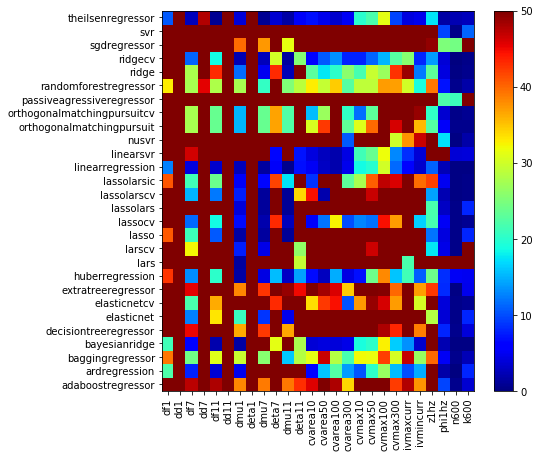

In [8]:
def df_to_heatmap(df):
    '''
    Plot a heatmap from 2D data in a Pandas DataFrame. The y-axis labels 
    should be index names, and x-axis labels should be column names.
    '''
    plt.pcolor(scoredf, cmap='jet', vmin=0, vmax=50)
    plt.yticks(np.arange(0.5, len(scoredf.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(scoredf.columns), 1),
               df.columns, rotation='vertical')
    fig = plt.gcf()
    fig.set_size_inches(7, 7)
    plt.colorbar()
    plt.show()

df_to_heatmap(scoredf)

In [9]:
from matplotlib import cm





for tar in scoredict:

    colors = cm.Set3(np.arange(len(scoredict[tar].values())) / len(scoredict[tar]))

    scoredf[tar].loc[]


'''
    plt.bar(np.arange(len(scoredict[tar])),
            list(scoredict[tar].values()),
            align='center', width=0.5, color=colors)

    plt.xticks(np.arange(len(scoredict[tar])),
               list(scoredict[tar].keys()),
               rotation='vertical')

    fig = plt.gcf()
    fig.set_size_inches(10, 4)
    plt.title(tar.upper(), fontsize=16)
    plot_setup(labels=['Model', 'Avg. residual (%)'],
               setlimits=True,
               limits=[-0.5, len(scoredict[tar])-0.5, 0, 100])
    plt.show()

'''

SyntaxError: ignored

In [0]:
scoredf.loc['lars']

# Build models in Keras / Tensorflow

For building a neural network regressino model, we will use Keras, a wrapper for Google's 
Tensorflow library.

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import seed
from tensorflow import set_random_seed
import keras
from keras import optimizers
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from timeit import default_timer as timer

 ## Fix the random number generators

 Ransom number generators are often used to create initial values for
 weights and biases of the model. Here we fix the numpy and tensorflow random
  number generators so we can reproduce the model results each time we run the
  code. This is not esential but it helps for judging the model performance 
  when a model parameter is changed, since our model will always begin in
  the same initialization state.

In [0]:
seed(1)
set_random_seed(2)

## Create a callback function

When we train an artificial neural network, it is difficult to tell how many
layers and how many neurons to use. To get some insights, we want to know how
the weights and biases of each layer and neuron are changing during training.

For reading the value of weights at each training epoch, we write a special
Keras callback function which runs at each epoch and stores the weights and
biases of each neuron in every layer. This will be called when we fit the
neural network model.

In [0]:
class GetWeights(Callback):
    '''
    Custom Keras callback which collects values of weights and biases
    after each epoch of training the model. Should be used like this:
    gw = GetWeights()
    model.fit(callbacks=[gw])
    wd = gw.weight_dict
    '''
    def __init__(self):
        super(GetWeights, self).__init__()
        self.weight_dict = {}
    def on_epoch_end(self, epoch, logs=None):
        # this function runs at the end of each epoch
        # loop over each layer and get weights and biases
        for layer_i in range(len(self.model.layers)):
            w = self.model.layers[layer_i].get_weights()[0]
            b = self.model.layers[layer_i].get_weights()[1]
            # save all weights and biases inside a dictionary
            if epoch == 0:
                # create array to hold weights and biases
                self.weight_dict['w_'+str(layer_i+1)] = w
                self.weight_dict['b_'+str(layer_i+1)] = b
            else:
                # append new weights to previously-created weights array
                self.weight_dict['w_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['w_'+str(layer_i+1)], w))
                # append new weights to previously-created weights array
                self.weight_dict['b_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['b_'+str(layer_i+1)], b)) 

Now we can build the structure of the neural network, set the optimizers,
compile the model, and finally fit (train) it. We plot the history of the model
during training to track how many epochs it should complete before the
model starts overtraining (validation loss begins increasing).

In [0]:
# instantiate our previously-defined callback class       
gw = GetWeights()

# create the neural network structure
train_start_time = timer()
model = Sequential([
                    Dense(24, activation='relu',
                          input_shape=(train_inp_s.shape[1:])),

                    #Dense(4, activation='relu'),
                    #Dense(8, activation='relu',
                    #Dense(4, activation='relu'),
                    #Dropout(.2, seed=1),
                  Dense(1)])

# set hyperparameters related to the stochastic gradient descent optimizer
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

# compile the model with optimizer and loss function
model.compile(loss='mean_squared_error', optimizer=sgd)

# train the model
epochs = 5

history = model.fit(train_inp_s, train_tar_s,
                   validation_split=0.15,
                   epochs=epochs,
                   batch_size=500,
                   verbose=1,
                   callbacks=[gw])
print('training time = %.1f sec (%.2f min)' %(timer()-train_start_time,
                                 (timer()-train_start_time)/60))

# plot loss during training
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.semilogy(loss, c='k')
plt.semilogy(val_loss, c='r')
plot_setup(['Epoch', 'Loss'])
plt.legend(['training', 'validation'])
plt.show()

In [0]:
import matplotlib.gridspec as gridspec
from matplotlib import cm

wd = gw.weight_dict

# loop over each epoch in the training session
for epoch in range(0, 3, 1):
    # layout the figure based on the number of layers
    fig = plt.figure(figsize=(15, 6))
    gs_stretch = 6
    gs = gridspec.GridSpec(6, int(len(wd)/2)*gs_stretch, figure=fig)
    gs.update(left=0.1, right=0.9, top=0.85, bottom=0.03, wspace=0.01, hspace=2)

    # loop over each array of weights and biases
    for key_i, key in enumerate(wd):
        # print(str(key) + ' shape: %s' %str(np.shape(gw.weight_dict[key])))
        # check if key is a weights key
        if 'w' in key:
            # row and column to place plot
            row, col = gs.get_geometry()[0]-1, gs_stretch*int(key_i/2)+int(key_i/2)
            # normal layer
            if key != list(wd.keys())[-2]:
                plt.subplot(gs[:row, col:col+gs_stretch]).axis('off')
                plt.gca().set_title('L-'+str(1+int(key_i/2))+' weights', fontsize=18)
            # output layer
            else:
                plt.subplot(gs[:row, col]).axis('off')
                plt.gca().set_title('Output\nweights', fontsize=18)
        # check if key is a biases key
        if 'b' in key:
            # normal layer
            if key != list(wd.keys())[-1]:
                plt.subplot(gs[row, col:col+gs_stretch]).axis('off') 
                plt.gca().set_title('L-'+str(1+int(key_i/2))+' biases', fontsize=18) 
            # output layer
            else:
                plt.subplot(gs[row, col]).axis('off')
                plt.gca().set_title('Output\nbiases', fontsize=18)

        # generate the heatmap of weight/bias values
        plt.imshow(wd[key][:,:,epoch],
                aspect='auto',
                cmap=plt.get_cmap('coolwarm'),
                interpolation='nearest')

    fig.suptitle('Epoch '+str(epoch), fontsize=22)
    plt.axis('off')
    plt.show()
    # save the image to file
    save_heatmaps = False
    if save_heatmaps:
        fig_filename = 'epoch_'+str(epoch).zfill(5)+'.png'
        fig.savefig(fig_filename, dpi=200)
        files.download(fig_filename)

## Animate the weights into a video clip

We want to visualize how the neural network model weights and biases are 
changing as the model is trained so we can tell which layers are 
superfluous and merely contribute to longer training times and overfitting.

We use the OpenCV library (imported as cv2) to compile the saved images of our
 weights in a short video. 

In [0]:
from glob import glob
import cv2

def create_video(image_list, video_name, fps=8, reverse=False):
    # create video out of images saved in a folder
    # frames per second (fps) and order of the images can be reversed 
    # using the **kwargs.
    if reverse: image_list = image_list[::-1]
    frame = cv2.imread(image_list[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, -1, fps, (width,height))
    for image in image_list:
        video.write(cv2.imread(image))
    cv2.destroyAllWindows()
    video.release()
    return video

image_list = sorted(glob(r'C:\Users\a6q\exp_data\ANN_weight_maps\/*.png'))

make_video = False
if make_video:
    video = create_video(
        image_list, r'C:\Users\a6q\Desktop\ANN_weightmap.avi', fps=4)

In [0]:
'''
#%% make predictions
trained_model_s = model.predict(train_inp_s), 
future_predictions_s = model.predict(test_inp_s)

#%% get sparse matrices which have same shape as scaled 
# training/testing data so we can unscale ANN results
# so we can unscale using the same scaler as before
trained_model_mat_s = np.zeros((train_size,len(input_mat[0])))
future_predictions_mat_s = np.zeros((test_size,len(input_mat[0])))
test_tar_mat_s = np.copy(future_predictions_mat_s)

# insert our data into its corresponding column of each sparse matrix
trained_model_mat_s[:,tar_col] = np.ndarray.flatten(np.array(trained_model_s))
future_predictions_mat_s[:,tar_col] = np.ndarray.flatten(future_predictions_s)


#%%# unscale our data
trained_model = scaler.inverse_transform(trained_model_mat_s)[:,tar_col]
future_pred = scaler.inverse_transform(future_predictions_mat_s)[:,tar_col]
train_tar = sig[:train_size]

plt.plot(time[train_size:],future_pred, c='r', label='prediction')
plt.scatter(time, sig, c='k', s=3, alpha=0.1, label='measured')
plt.plot(time[:train_size], trained_model, c='b', alpha=0.5, label='model')
plt.xlabel('Time (min)', fontsize=label_size)
plt.ylabel('Amplitude', fontsize=label_size)
plt.legend()
plt.show()

#%% make error calculations
tot_model = np.append(trained_model, future_pred)
error_raw = np.subtract(sig, tot_model)
percent_error = 100*np.abs(error_raw)/np.max(np.abs(sig))

fig, ax1 = plt.subplots()
ax1.plot(time, pressure, linewidth=0.5, c='b')
ax1.set_xlabel('Time (min)', fontsize=label_size)
ax1.set_ylabel('Pressure', color='b', fontsize=label_size)

ax2 = ax1.twinx()
ax2.plot(time, percent_error, linewidth=0.5, c='r')
ax2.set_ylabel('% error', color='r', fontsize=label_size)
ax2.tick_params('y', colors='r')
plt.show()

print('avg. percent error = %.2f' %(np.mean(percent_error)))
'''

In [0]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold

# #############################################################################
# Retrieve the data from Internet

# The data is from 2003 - 2008. This is reasonably calm: (not too long ago so
# that we get high-tech firms, and before the 2008 crash). This kind of
# historical data can be obtained for from APIs like the quandl.com and
# alphavantage.co ones.

symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'McDonald\'s',
    'PEP': 'Pepsi',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas Instruments',
    'XRX': 'Xerox',
    'WMT': 'Wal-Mart',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}


symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    print('Fetching quote history for %r' % symbol, file=sys.stderr)
    url = ('https://raw.githubusercontent.com/scikit-learn/examples-data/'
           'master/financial-data/{}.csv')
    quotes.append(pd.read_csv(url.format(symbol)))
    print(len(pd.read_csv(url.format(symbol))))
close_prices = np.vstack([q['close'] for q in quotes])
open_prices = np.vstack([q['open'] for q in quotes])

print(np.shape(close_prices))
print(np.shape(open_prices))

# The daily variations of the quotes are what carry most information
variation = close_prices - open_prices
print(np.shape(variation))
#variation = np.random.random((len(names), 9))

# #############################################################################
# Learn a graphical structure from the correlations
edge_model = covariance.GraphicalLassoCV(cv=5)

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

# #############################################################################
# Cluster using affinity propagation

_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

# #############################################################################
# Find a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

# #############################################################################
# Visualization
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.nipy_spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

In [0]:
symbols, names = np.array(sorted(symbol_dict.items())).T
names